In [1]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

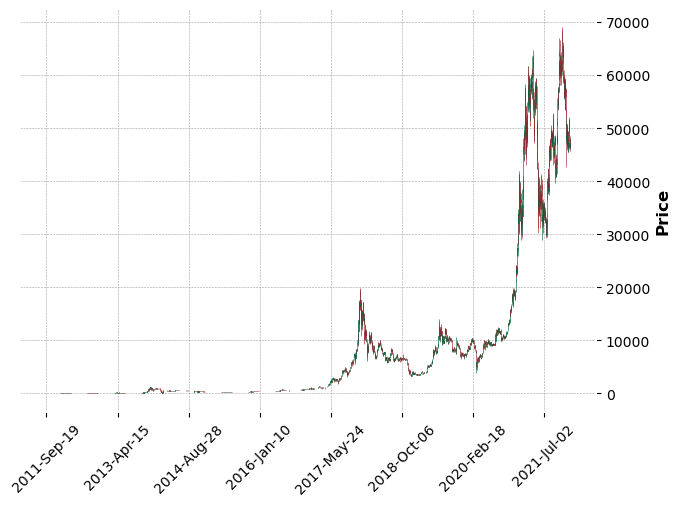

In [2]:
name_datos = 'BITCOIN'

df = pd.read_csv(name_datos + '.csv', index_col = 0)
if name_datos == 'BITCOIN':
    df = df[200:]
df.index = pd.to_datetime(df.index)
mpf.plot(df, type = 'candlestick', style = 'charles')

In [3]:
# Método para obtener el beneficio de un conjunto de datos.

def obtener_beneficio(df, lista):
    liquido = 500
    acciones = 500 / df.iloc[0]['Open']
    for fecha in lista:
        if lista[fecha] == 'vender':
            liquido += (df.loc[fecha]['Open'] * acciones)
            acciones = 0
        elif lista[fecha] == 'comprar':
            acciones += (liquido / df.loc[fecha]['Open'])
            liquido = 0
    final = liquido + (acciones * df.iloc[-1]['Close'])
    return final

In [4]:
# Método para obtener los valores de la progresión monetaria.

def progresion_dinero(df, lista):
    final = {}
    final[df.iloc[0].name] = 1000
    liquido = 500
    acciones = 500 / df.iloc[0]['Open']
    for fecha in lista:
        if lista[fecha] == 'vender':
            liquido += (df.loc[fecha]['Open'] * acciones)
            acciones = 0
            final[fecha] = liquido
        elif lista[fecha] == 'comprar':
            acciones += (liquido / df.loc[fecha]['Open'])
            liquido = 0
    close = liquido + (acciones * df.iloc[-1]['Close'])
    final[df.iloc[-1].name] = close
    return final

In [5]:
# Métodos del Ichimoku. El último método es el que nos dice la tendencia para cada día.

def media_por_maximos(data, n):
    fechas = data.index
    alto = [np.nan] * n
    bajo = [np.nan] * n
    resultado = {}
    for i in range(len(fechas)):
        c, o, h, l = data.loc[fechas[i]]
        resultado[fechas[i]] = (max(alto) + min(bajo)) / 2
        alto.append(h)
        bajo.append(l)
        del alto[0]
        del bajo[0]
    return resultado

def crear_senkou_span_a(a, b):
    fechas = list(b)
    final = {a: np.nan for a in fechas}
    for i in range(len(fechas) - 26):
        fecha_a = fechas[i]
        fecha_b = fechas[i + 26]
        c = a[fecha_a]
        e = b[fecha_a]
        final[fecha_b] = (c + e) / 2
    return final

def crear_chikou_span(data):
    fechas = data.index
    final = {a: np.nan for a in fechas}
    for i in range(len(fechas) - 26):
        fecha_a = fechas[i]
        fecha_b = fechas[i + 26]
        c, o, h, l = data.loc[fecha_a]
        final[fecha_b] = c
    return final

def tendencias_colores(df, senkou_span_a, senkou_span_b):
    final = {}
    fechas = list(senkou_span_b)
    for fecha in fechas:
        c, o, h, l = df.loc[fecha]
        a = senkou_span_a[fecha]
        b = senkou_span_b[fecha]
        mini, maxi = min(a, b), max(a, b)
        color = 'black'
        if c > maxi:
            color = 'green'
        elif c < mini:
            color = 'red'
        final[fecha] = color
    return final

def tendencia_anterior(df, colores, n):
    final = {}
    fechas = list(colores)
    orden = {fechas[i]: i for i in range(len(fechas))}
    conversor = {'green': 'alcista', 'red': 'bajista', 'black': 'duda'}
    for fecha in orden:
        indice = orden[fecha]
        if indice < n:
            final[fecha] = 'nada'
        else:
            dic = {}
            lista = fechas[indice - n:indice]
            for elem in lista:
                color = colores[elem]
                if color not in dic:
                    dic[color] = 0
                dic[color] += 1
            total = sum([dic[a] for a in dic])
            resul = {a: dic[a] / total for a in dic}
            t, winner = max([(resul[a], a) for a in resul])
            final[fecha] = conversor[winner]
    return final

def ichimoku_completo(df, dias):
    tenkan_sen = media_por_maximos(df, 9)
    kijun_sen = media_por_maximos(df, 26)
    
    senkou_span_a = crear_senkou_span_a(tenkan_sen, kijun_sen)
    senkou_span_b = media_por_maximos(df, 52)
    
    chikou_span = crear_chikou_span(df)
    resul = tendencias_colores(df, senkou_span_a, senkou_span_b)
    final = tendencia_anterior(df, resul, dias)
    return final

In [6]:
# Pareja 1.

def martillo_subida(data, valores, indice): # p333, f1, c1
    # Venimos de tendencia bajista
    i = data.index[indice]
    a = (valores[i] == 'bajista')
    c, o, h, l = data.loc[i]
    if o > c and o == h:
        return True and a
    return False

def martillo_bajada(data, valores, indice): # p333, f1, c2
    # Venimos de tendencia alcista
    i = data.index[indice]
    a = (valores[i] == 'alcista')
    c, o, h, l = data.loc[i]
    if o > c and o == h:
        return True and a
    return False

In [7]:
# Pareja 2.

def martillo_invertido_subida(data, valores, indice): # p333, f1, c3
    # Venimos de tendencia bajista
    i_1 = data.index[indice - 1]
    a = (valores[i_1] == 'bajista')
    i_2 = data.index[indice]
    c_1, o_1, h_1, l_1 = data.loc[i_1]
    c_2, o_2, h_2, l_2 = data.loc[i_2]
    if c_2 < o_2 < c_1 < o_1 and c_2 == l_2:
        return True and a
    return False

def estrella_fugaz_bajada(data, valores, indice): # p333, f2, c1
    # Venimos de tendencia alcista
    i_1 = data.index[indice - 1]
    a = (valores[i_1] == 'alcista')
    i_2 = data.index[indice]
    c_1, o_1, h_1, l_1 = data.loc[i_1]
    c_2, o_2, h_2, l_2 = data.loc[i_2]
    if o_1 < c_1 < c_2 < o_2 and c_2 == l_2:
        return True and a
    return False

In [8]:
# Pareja 3.

def sujecion_por_cinturon_subida(data, valores, indice): # p333, f2, c2
    # Venimos de tendencia bajista
    i = data.index[indice]
    a = (valores[i] == 'bajista')
    c, o, h, l = data.loc[i]
    if o < c and o == l:
        return True and a
    return False

def sujecion_por_cinturon_bajada(data, valores, indice): # p333, f2, c3
    # Venimos de tendencia alcista
    i = data.index[indice]
    a = (valores[i] == 'alcista')
    c, o, h, l = data.loc[i]
    if o > c and o == h:
        return True and a
    return False

In [9]:
# Pareja 4.

def envolvente_subida(data, valores, indice): # p334, f1, c1
    # Venimos de tendencia bajista
    i_1 = data.index[indice - 1]
    a = (valores[i_1] == 'bajista')
    i_2 = data.index[indice]
    c_1, o_1, h_1, l_1 = data.loc[i_1]
    c_2, o_2, h_2, l_2 = data.loc[i_2]
    if o_2 < c_1 < o_1 < c_2:
        return True and a
    return False

def envolvente_bajada(data, valores, indice): # p334, f1, c2
    # Venimos de tendencia alcista
    i_1 = data.index[indice - 1]
    a = (valores[i_1] == 'alcista')
    i_2 = data.index[indice]
    c_1, o_1, h_1, l_1 = data.loc[i_1]
    c_2, o_2, h_2, l_2 = data.loc[i_2]
    if c_2 < o_1 < c_1 < o_2:
        return True and a
    return False

In [10]:
# Pareja 5.

def harami_subida(data, valores, indice): # p334, f1, c3
    # Venimos de tendencia bajista
    i_1 = data.index[indice - 1]
    a = (valores[i_1] == 'bajista')
    i_2 = data.index[indice]
    c_1, o_1, h_1, l_1 = data.loc[i_1]
    c_2, o_2, h_2, l_2 = data.loc[i_2]
    if c_1 < o_2 < c_2 < o_1:
        return True and a
    return False

def harami_bajada(data, valores, indice): # p334, f2, c1
    # Venimos de tendencia alcista
    i_1 = data.index[indice - 1]
    a = (valores[i_1] == 'alcista')
    i_2 = data.index[indice]
    c_1, o_1, h_1, l_1 = data.loc[i_1]
    c_2, o_2, h_2, l_2 = data.loc[i_2]
    if o_1 < c_2 < o_2 < c_1:
        return True and a
    return False

In [11]:
# Pareja 6.

def cruz_harami_subida(data, valores, indice): # p334, f2, c2
    # Venimos de tendencia bajista
    i_1 = data.index[indice - 1]
    a = (valores[i_1] == 'bajista')
    i_2 = data.index[indice]
    c_1, o_1, h_1, l_1 = data.loc[i_1]
    c_2, o_2, h_2, l_2 = data.loc[i_2]
    if c_1 < o_2 < o_1 and o_2 == c_2:
        return True and a
    return False

def cruz_harami_bajada(data, valores, indice): # p334, f2, c3
    # Venimos de tendencia bajista
    i_1 = data.index[indice - 1]
    a = (valores[i_1] == 'alcista')
    i_2 = data.index[indice]
    c_1, o_1, h_1, l_1 = data.loc[i_1]
    c_2, o_2, h_2, l_2 = data.loc[i_2]
    if o_1 < o_2 < c_1 and o_2 == c_2:
        return True and a
    return False

In [12]:
# Pareja 7.

def tres_soldados_blancos_subida(data, valores, indice): # p335, f2, c1
    # Venimos de tendencia bajista
    i_1 = data.index[indice - 2]
    a = (valores[i_1] == 'bajista')
    i_2 = data.index[indice - 1]
    i_3 = data.index[indice]
    c_1, o_1, h_1, l_1 = data.loc[i_1]
    c_2, o_2, h_2, l_2 = data.loc[i_2]
    c_3, o_3, h_3, l_3 = data.loc[i_3]
    if o_1 < o_2 < c_1 < c_2 and o_2 < o_3 < c_2 < c_3:
        return True and a
    return False

def tres_cuervos_negros_bajada(data, valores, indice): # p335, f2, c1
    # Venimos de tendencia alcista
    i_1 = data.index[indice - 2]
    a = (valores[i_1] == 'alcista')
    i_2 = data.index[indice - 1]
    i_3 = data.index[indice]
    c_1, o_1, h_1, l_1 = data.loc[i_1]
    c_2, o_2, h_2, l_2 = data.loc[i_2]
    c_3, o_3, h_3, l_3 = data.loc[i_3]
    if c_2 < c_1 < o_2 < o_1 and c_3 < c_2 < o_3 < o_2:
        return True and a
    return False

In [13]:
# Pareja 8.

def linea_penetrante_subida(data, valores, indice): # p334, f3, c1
    # Venimos de tendencia bajista
    i_1 = data.index[indice - 1]
    a = (valores[i_1] == 'bajista')
    i_2 = data.index[indice]
    c_1, o_1, h_1, l_1 = data.loc[i_1]
    c_2, o_2, h_2, l_2 = data.loc[i_2]
    if o_2 < c_1 < c_2 < o_1:
        return True and a
    return False

def cubierta_de_nube_oscura_bajada(data, valores, indice): # p334, f3, c2
    # Venimos de tendencia alcista
    i_1 = data.index[indice - 1]
    a = (valores[i_1] == 'alcista')
    i_2 = data.index[indice]
    c_1, o_1, h_1, l_1 = data.loc[i_1]
    c_2, o_2, h_2, l_2 = data.loc[i_2]
    if o_1 < c_2 < c_1 < o_2:
        return True and a
    return False

In [14]:
# Pareja 9.

def estrella_matutina_subida(data, valores, indice): # p334, f2, c3
    # Venimos de tendencia bajista
    i_1 = data.index[indice - 2]
    a = (valores[i_1] == 'bajista')
    i_2 = data.index[indice - 1]
    i_3 = data.index[indice]
    c_1, o_1, h_1, l_1 = data.loc[i_1]
    c_2, o_2, h_2, l_2 = data.loc[i_2]
    c_3, o_3, h_3, l_3 = data.loc[i_3]
    if o_2 < c_2 < c_1 < o_1 and o_2 < c_2 < o_3 < c_3:
        return True and a
    return False

def estrella_vespertina_bajada(data, valores, indice): # p334, f3, c1
    # Venimos de tendencia alcista
    i_1 = data.index[indice - 2]
    a = (valores[i_1] == 'alcista')
    i_2 = data.index[indice - 1]
    i_3 = data.index[indice]
    c_1, o_1, h_1, l_1 = data.loc[i_1]
    c_2, o_2, h_2, l_2 = data.loc[i_2]
    c_3, o_3, h_3, l_3 = data.loc[i_3]
    if o_1 < c_1 < c_2 < o_2 and c_3 < o_3 < c_2 < o_2:
        return True and a
    return False

In [15]:
# Pareja 10.

def estrella_doji_subida(data, valores, indice): # p334, f3, c3
    # Venimos de tendencia bajista
    i_1 = data.index[indice - 1]
    a = (valores[i_1] == 'bajista')
    i_2 = data.index[indice]
    c_1, o_1, h_1, l_1 = data.loc[i_1]
    c_2, o_2, h_2, l_2 = data.loc[i_2]
    if o_2 < c_1 < o_1 and o_2 == c_2:
        return True and a
    return False

def estrella_doji_bajada(data, valores, indice): # p335, f1, c1
    # Venimos de tendencia alcista
    i_1 = data.index[indice - 1]
    a = (valores[i_1] == 'alcista')
    i_2 = data.index[indice]
    c_1, o_1, h_1, l_1 = data.loc[i_1]
    c_2, o_2, h_2, l_2 = data.loc[i_2]
    if o_1 < c_1 < o_2 and o_2 == c_2:
        return True and a
    return False

In [16]:
# Pareja 11.

def tres_dentro_arriba_subida(data, valores, indice): # p336, f3, c1
    # Venimos de tendencia bajista
    i_1 = data.index[indice - 2]
    a = (valores[i_1] == 'bajista')
    i_2 = data.index[indice - 1]
    i_3 = data.index[indice]
    c_1, o_1, h_1, l_1 = data.loc[i_1]
    c_2, o_2, h_2, l_2 = data.loc[i_2]
    c_3, o_3, h_3, l_3 = data.loc[i_3]
    if c_1 < o_2 < c_2 < o_1 and o_2 < o_3 < c_2 < c_3:
        return True and a
    return False

def tres_dentro_abajo_bajada(data, valores, indice): # p336, f3, c2
    # Venimos de tendencia alcista
    i_1 = data.index[indice - 2]
    a = (valores[i_1] == 'alcista')
    i_2 = data.index[indice - 1]
    i_3 = data.index[indice]
    c_1, o_1, h_1, l_1 = data.loc[i_1]
    c_2, o_2, h_2, l_2 = data.loc[i_2]
    c_3, o_3, h_3, l_3 = data.loc[i_3]
    if o_1 < c_2 < o_2 < c_1 and c_3 < c_2 < o_3 < o_2:
        return True and a
    return False

In [17]:
# Pareja 12.

def minimo_a_juego_subida(data, valores, indice): # p338, f1, c1
    # Venimos de tendencia bajista
    i_1 = data.index[indice - 1]
    a = (valores[i_1] == 'bajista')
    i_2 = data.index[indice]
    c_1, o_1, h_1, l_1 = data.loc[i_1]
    c_2, o_2, h_2, l_2 = data.loc[i_2]
    if c_2 < o_2 < o_1 and c_1 == c_2 == l_1 == l_2:
        return True and a
    return False

def maximo_a_juego_bajada(data, valores, indice): # p338, f1, c2
    # Venimos de tendencia alcista
    i_1 = data.index[indice - 1]
    a = (valores[i_1] == 'alcista')
    i_2 = data.index[indice]
    c_1, o_1, h_1, l_1 = data.loc[i_1]
    c_2, o_2, h_2, l_2 = data.loc[i_2]
    if o_1 < o_2 < c_2 and c_1 == c_2 == h_1 == h_2:
        return True and a
    return False

In [18]:
# Pareja 13.

def lineas_de_separacion_subida(data, valores, indice): # p338, f3, c3
    # Venimos de tendencia alcista
    i_1 = data.index[indice - 1]
    a = (valores[i_1] == 'alcista')
    i_2 = data.index[indice]
    c_1, o_1, h_1, l_1 = data.loc[i_1]
    c_2, o_2, h_2, l_2 = data.loc[i_2]
    if c_1 < o_1 < o_2 < c_2:
        return True and a
    return False

def lineas_de_separacion_bajada(data, valores, indice): # p339, f1, c1
    # Venimos de tendencia alcista
    i_1 = data.index[indice - 1]
    a = (valores[i_1] == 'alcista')
    i_2 = data.index[indice]
    c_1, o_1, h_1, l_1 = data.loc[i_1]
    c_2, o_2, h_2, l_2 = data.loc[i_2]
    if c_2 < o_2 < o_1 < c_1:
        return True and a
    return False

In [19]:
# Pareja 14.

def bebe_abandonado_subida(data, valores, indice): # p336, f1, c1
    # Venimos de tendencia bajista
    i_1 = data.index[indice - 2]
    a = (valores[i_1] == 'bajista')
    i_2 = data.index[indice - 1]
    i_3 = data.index[indice]
    c_1, o_1, h_1, l_1 = data.loc[i_1]
    c_2, o_2, h_2, l_2 = data.loc[i_2]
    c_3, o_3, h_3, l_3 = data.loc[i_3]
    if c_2 < c_1 < o_1 and o_2 == c_2 and c_2 < o_3 < c_3:
        return True and a
    return False

def bebe_abandonado_bajada(data, valores, indice): # p336, f1, c2
    # Venimos de tendencia alcista
    i_1 = data.index[indice - 2]
    a = (valores[i_1] == 'alcista')
    i_2 = data.index[indice - 1]
    i_3 = data.index[indice]
    c_1, o_1, h_1, l_1 = data.loc[i_1]
    c_2, o_2, h_2, l_2 = data.loc[i_2]
    c_3, o_3, h_3, l_3 = data.loc[i_3]
    if o_1 < c_1 < c_2 and o_2 == c_2 and c_3 < o_3 < c_2:
        return True and a
    return False

In [20]:
# Pareja 15.

def tres_fuera_arriba_subida(data, valores, indice): # p336, f3, c3
    # Venimos de tendencia bajista
    i_1 = data.index[indice - 2]
    a = (valores[i_1] == 'bajista')
    i_2 = data.index[indice - 1]
    i_3 = data.index[indice]
    c_1, o_1, h_1, l_1 = data.loc[i_1]
    c_2, o_2, h_2, l_2 = data.loc[i_2]
    c_3, o_3, h_3, l_3 = data.loc[i_3]
    if o_2 < c_1 < o_1 < c_2 and o_2 < o_3 < c_2 < c_3:
        return True and a
    return False

def tres_fuera_abajo_bajada(data, valores, indice): # p337, f1, c1
    # Venimos de tendencia alcista
    i_1 = data.index[indice - 2]
    a = (valores[i_1] == 'alcista')
    i_2 = data.index[indice - 1]
    i_3 = data.index[indice]
    c_1, o_1, h_1, l_1 = data.loc[i_1]
    c_2, o_2, h_2, l_2 = data.loc[i_2]
    c_3, o_3, h_3, l_3 = data.loc[i_3]
    if c_2 < o_1 < c_1 < o_2 and c_3 < c_2 < o_3 < o_2:
        return True and a
    return False

In [21]:
# Pareja 16.

def patada_subida(data, valores, indice): # p337, f1, c2
    i_1 = data.index[indice - 1]
    i_2 = data.index[indice]
    c_1, o_1, h_1, l_1 = data.loc[i_1]
    c_2, o_2, h_2, l_2 = data.loc[i_2]
    if c_1 < o_1 < o_2 < c_2:
        return True
    return False

def patada_bajada(data, valores, indice): # p337, f1, c3
    i_1 = data.index[indice - 1]
    i_2 = data.index[indice]
    c_1, o_1, h_1, l_1 = data.loc[i_1]
    c_2, o_2, h_2, l_2 = data.loc[i_2]
    if c_2 < o_2 < o_1 < c_1:
        return True
    return False

In [22]:
# Generamos todas las posibles combinaciones de patrones de velas.

def generar_valores(n):
    dic = {}
    def backtracking(node):
        if len(node) == n:
            a = sum(node)
            if a != 0:
                if a not in dic:
                    dic[a] = []
                dic[a].append(node)
        else:
            backtracking(node + [0])
            backtracking(node + [1])
    backtracking([])
    final = []
    for elem in dic:
        final += sorted(dic[elem], reverse = True)
    return final

In [23]:
# Método que coge las listas de 0s y 1s y las convierte en grupos de patrones.

def posibles_modelos(lista_patrones):
    posibles = {}
    indice = 1
    n = generar_valores(len(lista_patrones))
    for elem in n:
        lista = []
        for i in range(len(elem)):
            if elem[i] == 1:
                lista += lista_patrones[i]
        posibles[indice] = lista
        indice += 1
    return posibles

In [24]:
# Obtener las señales que genera cada patrón con el conjunto de datos.

def patrones_en_total(df, patrones, dias):
    final = ichimoku_completo(df, dias)
    fechas = df.index
    resultado = {patron.__name__: [] for patron in patrones}
    for i in range(len(df)):
        if dias <= i < len(df) - 1:
            for patron in patrones:
                valor = patron(df, final, i)
                if valor == True:
                    resultado[patron.__name__].append(df.index[i + 1])
    return resultado

In [25]:
# Método que indica, según las señales que hemos encontrado, cuáles van a cada modelo.

def reparto_total_y_beneficios(df, modelos, señales_captadas):
    final = {}
    for i in modelos:
        dic = {}
        patrones = modelos[i]
        for patron in patrones:
            todas = señales_captadas[patron.__name__]
            hacer = 'vender'
            if 'subida' in patron.__name__:
                hacer = 'comprar'
            for a in todas:
                dic[a] = hacer
        resul = {}
        n = sorted(dic)
        for elem in n:
            resul[elem] = dic[elem]
        final[i] = resul
    return final

In [26]:
# Filtro que sirve para usar solo los modelos donde todos los patrones tengan alguna señal.

def cortar_modelos_vacios(mod_orig, modelos, señales_captadas):
    pos = {}
    for i in range(len(mod_orig)):
        for elem in mod_orig[i]:
            pos[elem.__name__] = i
    nums = {i: 0 for i in range(len(mod_orig))}
    for a in señales_captadas:
        if len(señales_captadas[a]) == 0:
            nums[pos[a]] += 1
    vetados = []
    for i in nums:
        if nums[i] == 2:
            for elem in mod_orig[i]:
                vetados.append(elem)
    buenos = {}
    for i in modelos:
        t = True
        for elem in vetados:
            if elem in modelos[i]:
                t = False
                break
        if t == True:
            buenos[i] = modelos[i]
    return buenos

In [27]:
# Método que genera todas las señales para todas las combinaciones posibles, y crea todos los modelos.

def todo_el_calculo(df, patrones, dias):
    modelos = posibles_modelos(patrones)
    todos = modelos[list(modelos)[-1]]
    señales_captadas = patrones_en_total(df, todos, dias)
    modelos = cortar_modelos_vacios(patrones, modelos, señales_captadas)
    final = reparto_total_y_beneficios(df, modelos, señales_captadas)
    return final

In [28]:
orden_patrones = [[martillo_subida, martillo_bajada],#1#
                  [martillo_invertido_subida, estrella_fugaz_bajada],#2#
                  [envolvente_subida, envolvente_bajada],#3#
                  [sujecion_por_cinturon_subida, sujecion_por_cinturon_bajada],#4#
                  [harami_subida, harami_bajada],#5#
                  [cruz_harami_subida, cruz_harami_bajada],#6#
                  [tres_soldados_blancos_subida, tres_cuervos_negros_bajada],#7#
                  [linea_penetrante_subida, cubierta_de_nube_oscura_bajada],#8#
                  [minimo_a_juego_subida, maximo_a_juego_bajada],#9#
                  [estrella_matutina_subida, estrella_vespertina_bajada],#10#
                  [lineas_de_separacion_subida, lineas_de_separacion_bajada],#11#
                  [estrella_doji_subida, estrella_doji_bajada],#12#
                  [tres_dentro_arriba_subida, tres_dentro_abajo_bajada],#13#
                  [bebe_abandonado_subida, bebe_abandonado_bajada],#14#
                  [tres_fuera_arriba_subida, tres_fuera_abajo_bajada],#15
                  [patada_subida, patada_bajada]]#16#